# Analisis de algoritmos de clasificación aplicados a Dataset

## Importamos librerias

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
#Bibliotecas para generar gráficos
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

from sklearn import tree

## Importamos el dataset

In [70]:
bipolar_interviews=pd.read_csv('./diario.csv', sep=';')

## Limpieza de datos

In [71]:
bipolar_interviews=bipolar_interviews.replace(to_replace="No", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="Si", value=1)
bipolar_interviews=bipolar_interviews.replace(to_replace="NO", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="no", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="SI", value=1)

In [72]:
bipolar_interviews=bipolar_interviews.drop(columns=["Fecha","Hora de despertar","Hora a la que te dormiste","Ciclo menstrual"])

## Eliminamos valores de offset

In [73]:
#Calculamos limites de la distribucion de cafeina hasta 3 desviaciones estandar
mean_cafeina = bipolar_interviews.mean()[7]
std_cafeina = bipolar_interviews.std()[7]
lim_inf_caf = mean_cafeina - 3*std_cafeina
lim_sup_caf = mean_cafeina + 3*std_cafeina

#Calculamos limites de la distribución de cigarrillos hasta 3 desviaciones estandar
mean_cigarrillo=bipolar_interviews.mean()[6]
std_cigarrillo=bipolar_interviews.std()[6]
lim_inf_cig=mean_cigarrillo-3*std_cigarrillo
lim_sup_cig=mean_cigarrillo+3*std_cigarrillo

C:\Users\cris_\AppData\Local\Temp/ipykernel_21400/1727321591.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cafeina = bipolar_interviews.mean()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_21400/1727321591.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_cafeina = bipolar_interviews.std()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_21400/1727321591.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cigarrillo=bipolar_interviews.mean()[6]
C:\Users\cris_\AppDa

In [74]:
bipolar_trimmed=bipolar_interviews[(bipolar_interviews["Cafeína"]>=lim_inf_caf)&(bipolar_interviews["Cafeína"]<=lim_sup_caf)&(bipolar_interviews["Número de cigarrillos"]>=lim_inf_cig)&(bipolar_interviews["Número de cigarrillos"]<=lim_sup_cig)]

In [75]:
bipolar_trimmed

,Estado de ánimo,Motivación,Problemas de concentración y atención,Irritabilidad,Ansiedad,Calidad del sueño,Número de cigarrillos,Cafeína,Alcohol,Otras drogas,Código
0,2,2,3,3,3,3,34,150,0.0,0.0,D
1,2,2,3,3,3,3,38,150,0.0,0.0,D
2,2,1,3,3,3,3,39,120,0.0,0.0,D
3,1,2,2,2,2,3,34,120,0.0,0.0,D
4,1,1,3,2,2,2,32,150,0.0,0.0,D
...,...,...,...,...,...,...,...,...,...,...,...
654,3,2,3,2,0,1,2,200,1.0,1.0,G
655,2,3,0,0,0,0,0,60,0.0,0.0,G
657,-3,-3,1,2,2,1,0,60,0.0,0.0,G
658,-3,-3,4,4,4,2,0,21,0.0,0.0,G


In [76]:
feature_cols = ['Estado de ánimo','Motivación','Problemas de concentración y atención','Irritabilidad','Ansiedad','Calidad del sueño','Número de cigarrillos','Cafeína']
X=bipolar_trimmed[feature_cols]

In [77]:
y=bipolar_trimmed['Código']

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

## Algoritmo de KNN

In [80]:
scaler = StandardScaler()

In [81]:
scaler.fit(X_train)

StandardScaler()

In [82]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
# Se hace un barrido para los distintos valores de K, evaluando la exactitud del algoritmo (o puntuación)
k_range = range(1,30)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

Text(0, 0.5, 'Testing Accuracy')

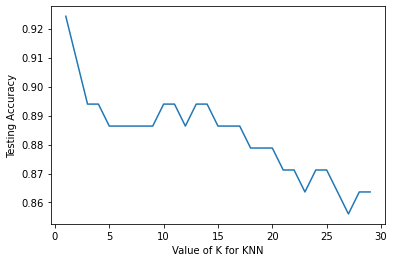

In [84]:
#Se grafica la relación entre K y su exactitud o puntuación
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')